In [ ]:
%load_ext autoreload
%autoreload 2

from FP567_Lib import *
from scipy import fft

import tensorflow_hub as hub
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# improve/change plot appearance
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
'''
After having their html removed, some of the update files are useless. Lets seperate them
'''
move_file_to_if_fnx(
    PATH_TO_RAW_GAME_UPDATES,
    PATH_TO_NOISY_JUNK_UPDATES,
    check_if_init_is_game_updates)

In [ ]:
'''
resoureces/raw_updates/
    by_year_updates
    by_day_updates
    game_updates
are the same updates, just oranized differently. 
Let's use the by_year_updates file and make some specfic yy/mm/dd_update files.
The by_year_updates have a certain form/pattern.
'''
unprocd_year_updates = os.path.join(PATH_TO_RAW_UPDATES, "by_year_updates")
for file in os.listdir(unprocd_year_updates):
    print(file[:4])
    yy = file[2:4]
    lines = open(os.path.join(unprocd_year_updates, file), "r").readlines()
    i = 0
    while i < len(lines):
        toks = lines[i].split()
        if len(toks) == 2:
            maybe_month = toks[1].lower()
            if toks[0] == "##" and maybe_month in MONTHS:
                print(f"\t{maybe_month}")
                path_to_month_folder = os.path.join(
                    PATH_TO_PROCESSED_UPDATES,
                    yy,
                    word_month_to_number_month(maybe_month))
                os.makedirs(path_to_month_folder, exist_ok=True)
                i = i + 2
                update_line_toks = lines[i].split()
                while len(update_line_toks) > 0:
                    d = update_line_toks[1][:-2]
                    print(f"\t\t{d}")
                    # write this update as its own file at yy/m/d.
                    # if in here, maybe_month is now for sure a month
                    with open(os.path.join(path_to_month_folder, f"{d}.txt"), 'w') as f:
                        f.write(" ".join(update_line_toks[3:]))

                    i = i + 1
                    update_line_toks = lines[i].split()
        i = i + 1


In [ ]:
'''
Found another common pattern amongst some files with some extractable updates that are different than
those that we already got from above notebook cells.
The below code parses this pattern, saving the updates.
First, to more easily keep track of what I have procd and not, move those that I process over to
a "has_been_processed" sub folder.
'''
files_with_pattern = [
    "Combat_Achievements.html.clean",
    "Achievement_Diary.html.clean",
    "Polls.html.clean",
    "Shooting_Stars.html.clean"]
get_updates_from_certain_misc_updates_pattern(files_with_pattern)

In [ ]:
'''
Another found pattern of updates to extract:
## Year

day month
update
'''
files_with_pattern = ["Hidden_updates.html.clean"]
get_updates_from_other_certain_misc_updates_pattern(files_with_pattern)

In [29]:
'''
There is a table-like list of update title and their release dates. Let's include these titles
with the updates as they are somewhat informative.
'''
table = pd.read_table(
    os.path.join(PATH_TO_RAW_MISC_UPDATES_BEEN_PROCD, "postbag_table.txt"), sep='|')
table.columns = list(map(str.strip, table.columns))

In [ ]:
table[["Title", "Date"]].apply(save_table_as_updates, axis=1)

In [4]:
'''
Now, lets take all the organized txt files and combine those that represent the same days,
then embedd and save these.
'''
encoder_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedder = hub.load(encoder_url)

In [5]:
vect = embedder(["this is a sentence"])[0]
vect

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([ 0.02881767, -0.02020015,  0.01069628,  0.0385053 , -0.09253702,
        0.01752774, -0.04711751,  0.0478521 ,  0.01430713,  0.02635952,
        0.02157276, -0.04987606,  0.03023818,  0.11923701,  0.04333102,
       -0.11343763, -0.02569381,  0.00875983, -0.03205026, -0.03528893,
        0.065098  ,  0.07168703,  0.00487422, -0.00622953, -0.05483385,
        0.06636366,  0.02197697, -0.08987362,  0.03663914, -0.04186109,
        0.03020706, -0.02176558,  0.00683554, -0.04167067, -0.09498136,
       -0.03249762,  0.06278758,  0.04457697,  0.00825471, -0.02461435,
       -0.00744968,  0.00276056,  0.04595318,  0.0438056 , -0.06370507,
       -0.01170835, -0.05826195, -0.02410091, -0.035766  , -0.03617879,
       -0.01113707, -0.0866305 , -0.08743551,  0.00281444, -0.01570992,
       -0.04420159,  0.0287745 ,  0.03433856, -0.0100031 , -0.04693236,
        0.00529842, -0.05397878,  0.01005255, -0.01533142, -0.05143673,
       -0.011951

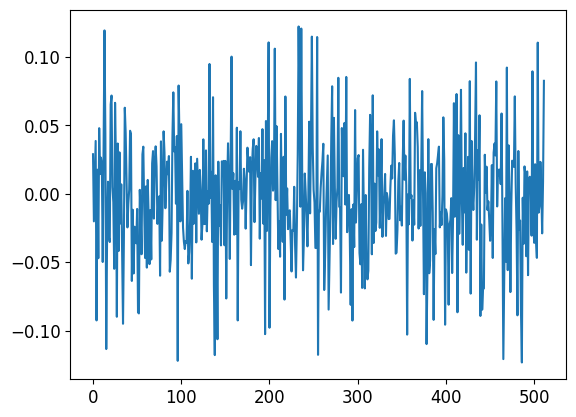

In [6]:
'''
The embedding that is made is 1x512, but for what we are trying to do, I think having
updates that long are going to be a problem, so to make them shorter, but still representitive,
gonna try using dct on the vectors.
'''
plt.plot(vect)

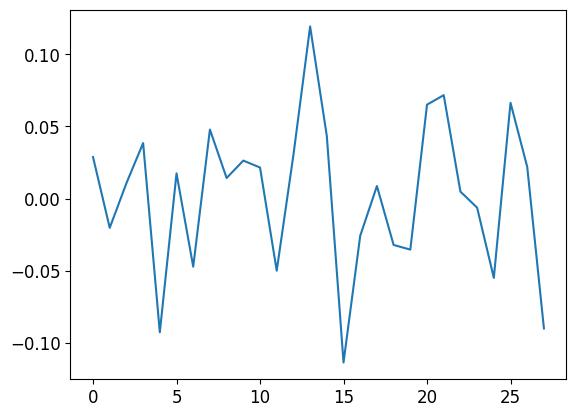

In [31]:
dct_vect = fft.idct(fft.dct(vect.numpy(), n=28))
plt.plot(dct_vect)

In [35]:
'''
Go through all the updates, combine, embed, save.
'''
# size_to_reduce_embedding_to = 28 will make it so that each unit of
# time in our model is 30 columns
size_to_reduce_embedding_to = 28
for year_directory in os.listdir(PATH_TO_PROCESSED_UPDATES_BY_YEAR):
    current_year_path = os.path.join(PATH_TO_PROCESSED_UPDATES_BY_YEAR, year_directory)
    # print(current_year_path)
    for month_directory in os.listdir(current_year_path):
        current_month_path = os.path.join(current_year_path, month_directory)
        # print(current_month_path)
        files = os.listdir(current_month_path)
        day_paths = [os.path.join(current_month_path, dd) for dd in files]
        dirs = [d_path for d_path in day_paths if '.' not in d_path and os.path.isdir(d_path)]
        for day_path in day_paths:
            days_embedded = []
            # just to make sure these are the .txt files i want
            if day_path.endswith(".txt"):
                try:
                    text = open(day_path, 'r').read()
                except:
                    print("Error on ", day_path)
                    continue
                # check if this file also has a directory
                day_dir_path = day_path.split('.')[0]
                days_embedded.append(day_dir_path)
                # just to make sure these are the directories i want
                if day_dir_path in dirs and not day_dir_path.endswith(".embedded") and not day_dir_path.endswith(".txt"):
                    for another_of_same_day_file_txt in os.listdir(day_dir_path):
                        if another_of_same_day_file_txt.endswith(".txt"):
                            text = text + f" {open(os.path.join(day_dir_path, another_of_same_day_file_txt), 'r').read()}"
                # embed and save this text embedding
                embedded_vect = embedder([text])[0]
                # do DCT on it, truncate, invert
                dct_embedded_vect = fft.idct(fft.dct(embedded_vect.numpy(), n=size_to_reduce_embedding_to))
                np.savetxt(f"{day_dir_path}.embedded", dct_embedded_vect)

            # for any days saved strictly as a directory (not up-one-level day.txt + day directory)
            for day_dir_path in [d for d in dirs if d not in days_embedded]:
                text = ""
                # just to make sure these are the directories i want
                if not day_dir_path.endswith(".embedded") and not day_dir_path.endswith(".txt"):
                    for another_of_same_day_file_txt in os.listdir(day_dir_path):
                        if another_of_same_day_file_txt.endswith(".txt"):
                            text = text + f" {open(os.path.join(day_dir_path, another_of_same_day_file_txt), 'r').read()}"
                    # embed and save this text embedding
                    embedded_vect = embedder([text])[0]
                    # do DCT on it, truncate, invert
                    dct_embedded_vect = fft.idct(fft.dct(embedded_vect.numpy(), n=size_to_reduce_embedding_to))
                    # embed and save this text embedding
                    np.save(f"{day_dir_path}.embedded", dct_embedded_vect)